# LIBRARIES 

In [1]:
# BASIC LIBRARIES
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#NPL 
import re
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim.downloader as api
from gensim.models import Word2Vec

# MODELS 

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DEEPGAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# LOAD THE DATA

In [2]:
dataset = load_dataset('SetFit/enron_spam')
dataset

Found cached dataset json (C:/Users/DEEPGAMING/.cache/huggingface/datasets/SetFit___json/SetFit--enron_spam-dfe3f29b8d121b65/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 31716
    })
    test: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 2000
    })
})

Train dataset: 

In [3]:
dataset.set_format(type='pandas')
train = dataset['train'][:]
train

,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13
...,...,...,...,...,...,...,...
31711,14628,"credit netco start up plan louise ,\nattached ...",0,ham,credit netco start up plan,"louise ,\nattached is the electronic version o...",2002-01-07
31712,16049,"everything you are looking for hello , visit o...",1,spam,everything you are looking for,"hello , visit our amazing\nonline shop !\nnows...",2005-03-26
31713,18024,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,start date : 2 / 5 / 02 ; hourahead hour : 18 ;,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,2002-02-05
31714,1639,corhshucker daren - - - -\nthe invoices are be...,0,ham,corhshucker,daren - - - -\nthe invoices are being paid by ...,2000-09-19


We look at the cases of HAM and SPAM in the training set: 

In [4]:
(train
  .groupby("label_text")
  .agg(frequency=("label_text", "count")))

,frequency
label_text,
ham,15553
spam,16163


Now, we do the same but with the test set: 

In [5]:
test = dataset['test'][:]
test

,message_id,text,label,label_text,subject,message,date
0,31329,expande tu imagen ! ! ! ! ! ! ! ! ! si no pued...,1,spam,expande tu imagen ! ! ! ! ! ! ! ! !,"si no puede ver este mail , entre a : http : /...",2005-01-19
1,3969,paliourg learning for life enlarge your member...,1,spam,paliourg learning for life,enlarge your member\nzenextend enlargement pil...,2004-05-06
2,27070,"cure premature ejaculation hello ,\ndid you ej...",1,spam,cure premature ejaculation,"hello ,\ndid you ejaculate before or within a ...",2005-07-17
3,2779,re : noms / actual flow for 3 / 19 / 01 we agr...,0,ham,re : noms / actual flow for 3 / 19 / 01,"we agree\n"" eileen ponton "" on 03 / 20 / 2001 ...",2001-03-20
4,2949,ehronline web address change this message is i...,0,ham,ehronline web address change,this message is intended for ehronline users o...,2001-03-30
...,...,...,...,...,...,...,...
1995,6578,re : book notes vince : look forward to meetin...,0,ham,re : book notes,vince : look forward to meeting you . . .\namy...,2000-07-26
1996,128,rollout schedule for unify real - time deal / ...,0,ham,rollout schedule for unify real - time deal / ...,a walk - thru / demo of this new functionality...,2000-01-11
1997,8485,anshuman shrivastava sandeep : vince has asked...,0,ham,anshuman shrivastava,sandeep : vince has asked me to coordinate wit...,2001-02-06
1998,7311,"re : good morning john ,\ni shall see christie...",0,ham,re : good morning,"john ,\ni shall see christie tomorrow and i sh...",2000-10-18


Frequency of spam and ham in the test set: 

In [6]:
(test
  .groupby("label_text")
  .agg(frequency=("label_text", "count")))

,frequency
label_text,
ham,992
spam,1008


Initially the two categories are balanced in the training set and also in the test set. 

# EXPLORATORY ANALYSIS

In [7]:
# Remove duplicate remarks 
dupl = train['text']

print('Number of duplicate observations:', len(dupl[dupl.duplicated()]))

Numero de observaciones duplicadas: 2904


In [8]:
# Remove duplicate observations based on a specific column 
train = train.drop_duplicates(subset=['text'])
train

,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13
...,...,...,...,...,...,...,...
31710,9144,"re : var meetings in houston shirley ,\ndo you...",0,ham,re : var meetings in houston,"shirley ,\ndo you think we can get another roo...",2001-04-19
31711,14628,"credit netco start up plan louise ,\nattached ...",0,ham,credit netco start up plan,"louise ,\nattached is the electronic version o...",2002-01-07
31712,16049,"everything you are looking for hello , visit o...",1,spam,everything you are looking for,"hello , visit our amazing\nonline shop !\nnows...",2005-03-26
31713,18024,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,start date : 2 / 5 / 02 ; hourahead hour : 18 ;,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,2002-02-05


In [9]:
train.describe()

,message_id,label
count,28812.000000,28812.000000
mean,16779.907018,0.480008
std,9826.714993,0.499609
min,0.000000,0.000000
25%,7990.750000,0.000000
50%,16969.500000,0.000000
75%,25219.500000,1.000000
max,33714.000000,1.000000


In [10]:
# Remove observations with text length equal to zero in case there are any in our dataset. 
train = train[train['text'].apply(len) > 0]

Once we have cleaned the database and removed duplicate observations and empty observations, we show a graph of how the two labels are distributed in our dataset:

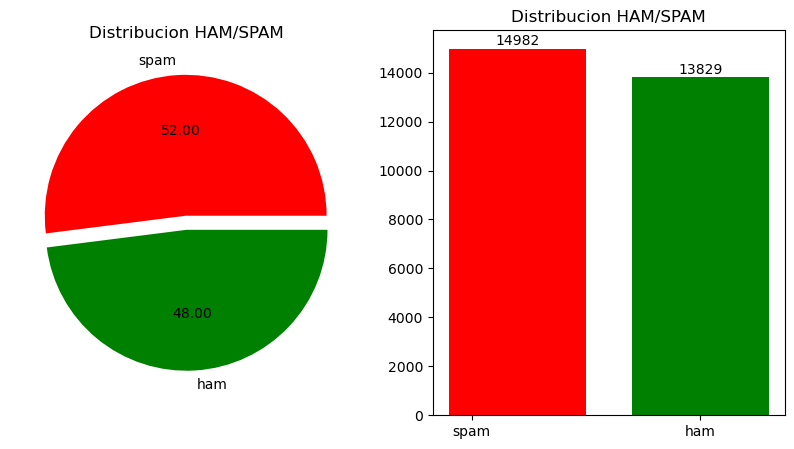

In [11]:
label = train['label_text']

# Definir la lista de colores
colors = ['red', 'green']

plt.figure(figsize=[10, 5])

# Gráfico de pastel
plt.subplot(121)
plt.pie(x=label.value_counts(),
        labels=label.unique(),
        colors=colors,
        explode=[0.05, 0.05],
        autopct='%.2f')
plt.title('Distribucion HAM/SPAM')

# Gráfico de barras
plt.subplot(122)
bars = plt.bar(x=[0.2, 1],
               height=label.value_counts(),
               width=0.6,
               color=colors)
plt.xticks(range(2), label.unique())
plt.title('Distribucion HAM/SPAM')

# Agregar texto con el número de observaciones encima de cada barra
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
             label.value_counts()[i], ha='center', va='bottom')

plt.show()

As the two classes are fairly balanced there will be no need for class balancing, where a balancing technique would be to add more data to the minority class.

### Display of the word clouds of each category

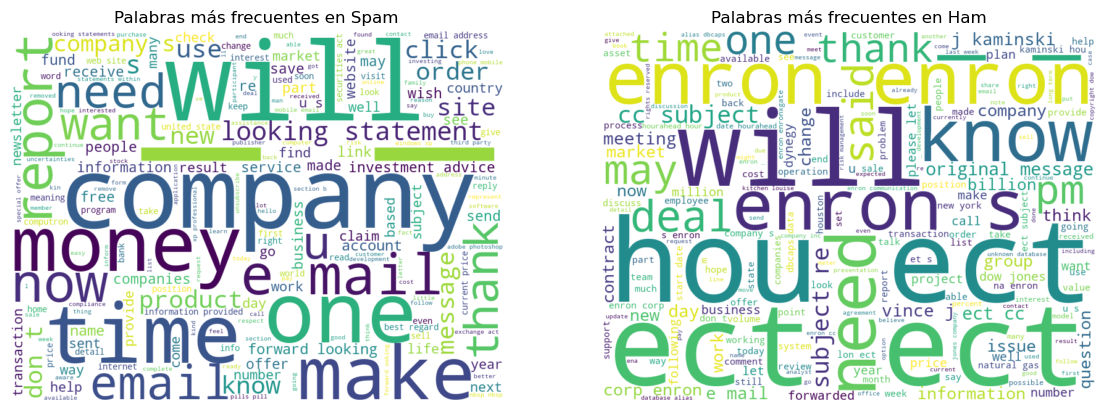

In [13]:
spam_words = ' '.join(train[train['label_text'] == 'spam']['text'])
ham_words = ' '.join(train[train['label_text'] == 'ham']['text'])

# White background settings for WordClouds
spam_wordcloud = WordCloud(width=800, height=600, background_color='white').generate(spam_words)
ham_wordcloud = WordCloud(width=800, height=600, background_color='white').generate(ham_words)

# Display of WordClouds with a white background
plt.figure(figsize = (14, 7))  # Adjust the size of the figure
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation = 'bilinear')
plt.title('Most frequent words in Spam')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation = 'bilinear')
plt.title('Most frequent words in Ham')
plt.axis('off')

# Saving images
plt.savefig('spam_wordcloud.png', bbox_inches = 'tight')  # Save the image of most frequent words in Spam
plt.savefig('ham_wordcloud.png', bbox_inches = 'tight')   # Save the image of most frequent words in  Ham

# Display images on the screen
plt.show()

### Most frequent words in each of the two categories 

In [14]:
spam_messages = train[train['label_text'] == 'spam']['text'].values
ham_messages = train[train['label_text'] == 'ham']['text'].values

spam_tokens = []
for message in spam_messages:
    tokens = word_tokenize(message)
    spam_tokens.extend(tokens)

ham_tokens = []
for message in ham_messages:
    tokens = word_tokenize(message)
    ham_tokens.extend(tokens)

In [15]:
stop_words = set(stopwords.words('english'))

spam_tokens = [token for token in spam_tokens if token.lower() not in stop_words]
ham_tokens = [token for token in ham_tokens if token.lower() not in stop_words]

In [16]:
spam_word_counts = Counter(spam_tokens)
ham_word_counts = Counter(ham_tokens)

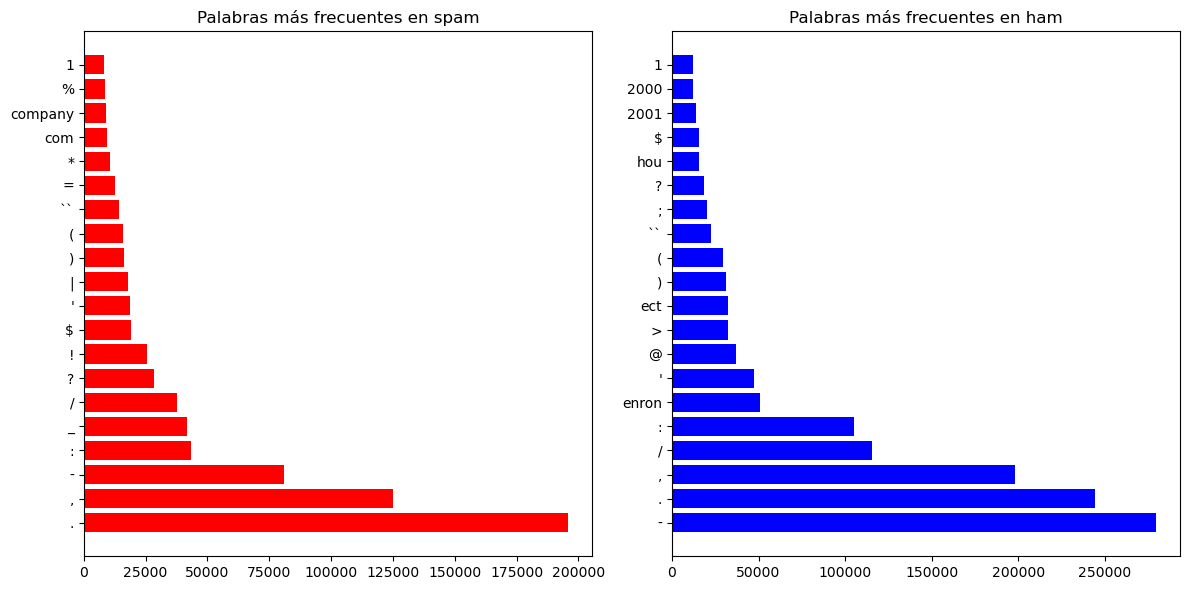

In [17]:
spam_top_words = spam_word_counts.most_common(20)
ham_top_words = ham_word_counts.most_common(20)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].barh(range(len(spam_top_words)), [count for word, count in spam_top_words], color='red')
axs[0].set_yticks(range(len(spam_top_words)))
axs[0].set_yticklabels([word for word, count in spam_top_words])
axs[0].set_title('Most frequent words in Spam')

axs[1].barh(range(len(ham_top_words)), [count for word, count in ham_top_words], color='blue')
axs[1].set_yticks(range(len(ham_top_words)))
axs[1].set_yticklabels([word for word, count in ham_top_words])
axs[1].set_title('Most frequent words in Ham')

plt.tight_layout()
plt.show()

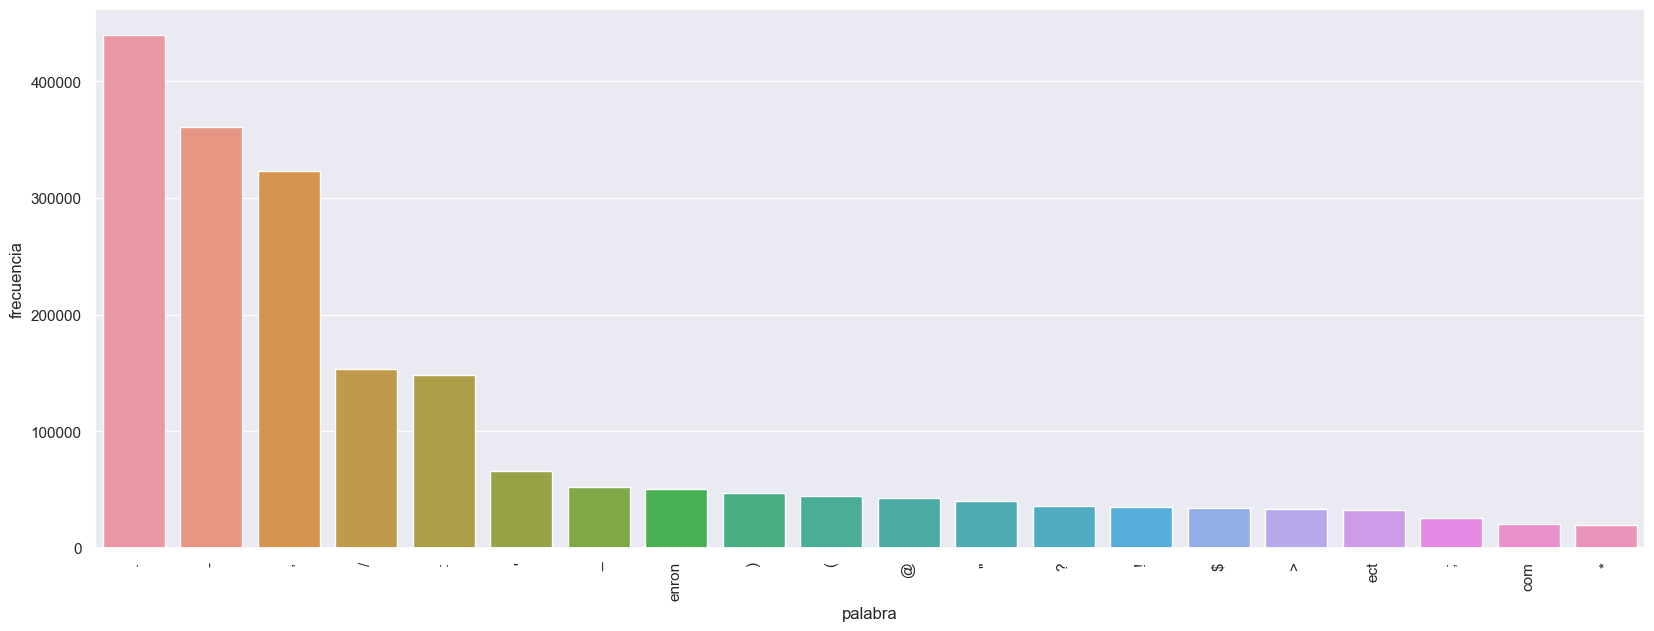

In [40]:
common_words = stopwords.words("english")
freq_common_words = Counter(" ".join(train['text']).split()).most_common(1000)
freq_common_words = [w for w in freq_common_words if not w[0] in common_words]
freq_common_words = freq_common_words[:20]

df = pd.DataFrame(freq_common_words)
df.columns = ['palabra','frecuencia']

sns.set()
plt.figure(figsize = (20, 7))
sns.barplot(data = df, x = 'Word', y = 'Frecuency')
plt.xticks(rotation = 90)
plt.show()

These two graphs don't tell us much about the most frequent words in each category, so we'll stick with the previous graph. Surely after doing all the preprocessing and eliminating characters and numbers, if we do this graph we would get the same words as the previous graph.  

## LENGTH OF OBSERVATIONS BY CATEGORY 

In [18]:
train = train.copy()  # Making a separate copy of the DataFrame

train['word_count'] = train['text'].apply(lambda x: len(x.split()))

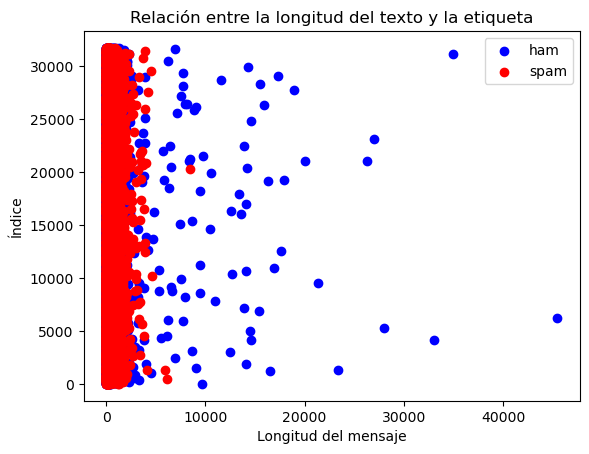

In [19]:
spam_text2 = train[train['label_text'] == 'spam']['word_count']
ham_text2 = train[train['label_text'] == 'ham']['word_count']

plt.scatter(ham_text2, train[train['label_text'] == 'ham'].index, color='blue', label='ham')
plt.scatter(spam_text2, train[train['label_text'] == 'spam'].index, color='red', label='spam')
plt.legend()
plt.title('Relationship between the length of the text and the label')
plt.xlabel('Message length')
plt.ylabel('Index')
plt.show()

In [20]:
spam_text2.describe()

count    13829.000000
mean       262.255333
std        383.713110
min          1.000000
25%         71.000000
50%        137.000000
75%        277.000000
max       8401.000000
Name: word_count, dtype: float64

In [21]:
ham_text2.describe()

count    14982.000000
mean       347.778334
std       1082.480224
min          1.000000
25%         74.000000
50%        174.000000
75%        368.000000
max      45450.000000
Name: word_count, dtype: float64

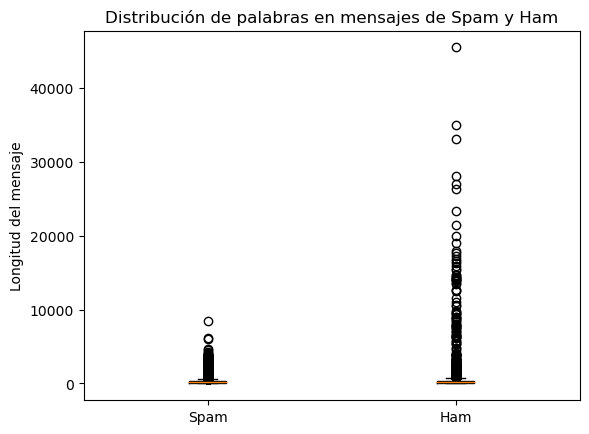

In [22]:
plt.boxplot([spam_text2, ham_text2])
plt.xticks([1, 2], ['Spam', 'Ham'])
plt.ylabel('Message length')
plt.title('Distribution of words in Spam and Ham messages')
plt.savefig('boxplot_spam_ham.png')  # Save the graphic as a PNG file
plt.show()

In [23]:
# Filter out remarks that are longer than 10,000 words
observaciones_mayor_10000 = train[train['word_count'] > 10000]

# Count how many observations meet the condition
cantidad_observaciones_mayor_10000 = len(observaciones_mayor_10000)

print(f"The number of observations with more than 10,000 words is: {cantidad_observaciones_mayor_10000}")

La cantidad de observaciones con más de 10,000 palabras es: 38


In the above graphs we can see that all texts that are longer than 10,000 words are all HAM. Therefore, SPAM messages are usually shorter than HAM messages. We could set a threshold to delimit the length of the messages and delete the messages that exceed this threshold. In this case, we will not use any threshold and will not delete any observations. As there are only 38 observations that are longer than 10,000 words, we will not remove any observations from the database. 

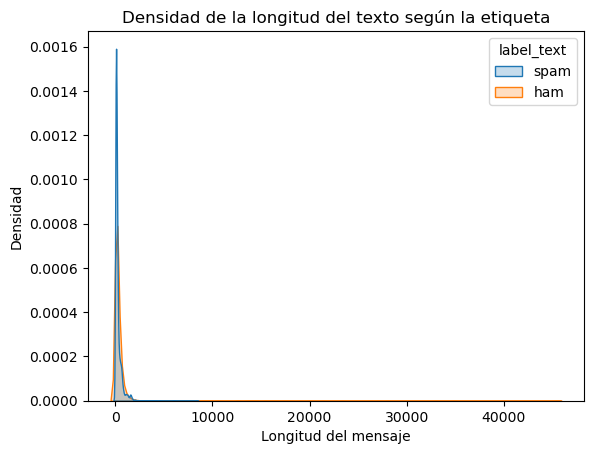

In [24]:
sns.kdeplot(data = train, x = 'word_count', hue = 'label_text', fill = True)
plt.title('Text length density according to label')
plt.xlabel('Message length')
plt.ylabel('Density')
plt.show()

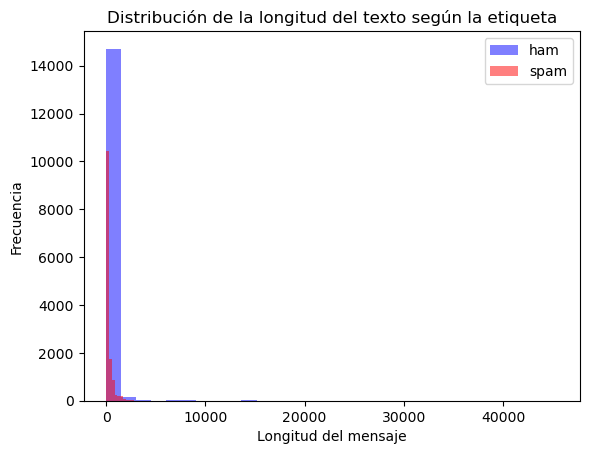

In [25]:
plt.hist(train[train['label_text'] == 'ham']['word_count'], bins = 30, alpha = 0.5, color = 'blue', label = 'ham')
plt.hist(train[train['label_text'] == 'spam']['word_count'], bins = 30, alpha = 0.5, color = 'red', label = 'spam')
plt.legend()
plt.title('Text length distribution according to the label')
plt.xlabel('Message length')
plt.ylabel('Frecuency')
plt.show()

In [26]:
train

,message_id,text,label,label_text,subject,message,date,word_count
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18,33
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19,239
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11,55
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12,33
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13,71
...,...,...,...,...,...,...,...,...
31710,9144,"re : var meetings in houston shirley ,\ndo you...",0,ham,re : var meetings in houston,"shirley ,\ndo you think we can get another roo...",2001-04-19,420
31711,14628,"credit netco start up plan louise ,\nattached ...",0,ham,credit netco start up plan,"louise ,\nattached is the electronic version o...",2002-01-07,24
31712,16049,"everything you are looking for hello , visit o...",1,spam,everything you are looking for,"hello , visit our amazing\nonline shop !\nnows...",2005-03-26,303
31713,18024,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,start date : 2 / 5 / 02 ; hourahead hour : 18 ;,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,2002-02-05,165


As we can see, we have not lost much information, in total we have only eliminated 1584 observations and considerably reduced the standard deviation of the two classes. 

In [36]:
# We save the training database
train = train.drop(['message_id','subject','message','date'], axis = 1) #We remove the columns that are not of interest to us.
train.to_csv('train.csv', index = False)

In [37]:
#We remove duplicate observations in the test and save the database.
dupl = test['text']

print('Number of Duplicates:', len(dupl[dupl.duplicated()]))

Number of Duplicates: 18


In [38]:
# Remove repeated observations based on a specific column
test = test.drop_duplicates(subset = ['text'])
test

,message_id,text,label,label_text,subject,message,date
0,31329,expande tu imagen ! ! ! ! ! ! ! ! ! si no pued...,1,spam,expande tu imagen ! ! ! ! ! ! ! ! !,"si no puede ver este mail , entre a : http : /...",2005-01-19
1,3969,paliourg learning for life enlarge your member...,1,spam,paliourg learning for life,enlarge your member\nzenextend enlargement pil...,2004-05-06
2,27070,"cure premature ejaculation hello ,\ndid you ej...",1,spam,cure premature ejaculation,"hello ,\ndid you ejaculate before or within a ...",2005-07-17
3,2779,re : noms / actual flow for 3 / 19 / 01 we agr...,0,ham,re : noms / actual flow for 3 / 19 / 01,"we agree\n"" eileen ponton "" on 03 / 20 / 2001 ...",2001-03-20
4,2949,ehronline web address change this message is i...,0,ham,ehronline web address change,this message is intended for ehronline users o...,2001-03-30
...,...,...,...,...,...,...,...
1995,6578,re : book notes vince : look forward to meetin...,0,ham,re : book notes,vince : look forward to meeting you . . .\namy...,2000-07-26
1996,128,rollout schedule for unify real - time deal / ...,0,ham,rollout schedule for unify real - time deal / ...,a walk - thru / demo of this new functionality...,2000-01-11
1997,8485,anshuman shrivastava sandeep : vince has asked...,0,ham,anshuman shrivastava,sandeep : vince has asked me to coordinate wit...,2001-02-06
1998,7311,"re : good morning john ,\ni shall see christie...",0,ham,re : good morning,"john ,\ni shall see christie tomorrow and i sh...",2000-10-18


In [39]:
test = test.drop(['message_id','subject','message','date'], axis = 1) #We remove the columns that are not of interest to us.
test.to_csv('test.csv', index = False)

## PREPROCESSING

In [3]:
test = pd.read_csv('test.csv')
test

,text,label,label_text
0,expande tu imagen ! ! ! ! ! ! ! ! ! si no pued...,1,spam
1,paliourg learning for life enlarge your member...,1,spam
2,"cure premature ejaculation hello ,\ndid you ej...",1,spam
3,re : noms / actual flow for 3 / 19 / 01 we agr...,0,ham
4,ehronline web address change this message is i...,0,ham
...,...,...,...
1995,re : book notes vince : look forward to meetin...,0,ham
1996,rollout schedule for unify real - time deal / ...,0,ham
1997,anshuman shrivastava sandeep : vince has asked...,0,ham
1998,"re : good morning john ,\ni shall see christie...",0,ham


In [4]:
train = pd.read_csv('train.csv')
train

,text,label,label_text
0,any software just for 15 $ - 99 $ understandin...,1,spam
1,perspective on ferc regulatory action client c...,0,ham
2,wanted to try ci 4 lis but thought it was way ...,1,spam
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham
4,looking for cheap high - quality software ? ro...,1,spam
...,...,...,...
28807,"re : var meetings in houston shirley ,\ndo you...",0,ham
28808,"credit netco start up plan louise ,\nattached ...",0,ham
28809,"everything you are looking for hello , visit o...",1,spam
28810,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham


In [5]:
train['text'][1542]

'time magazine article on pain relief stop hurting !\nvicodln - pain relief ! order\nenough\nthis is an auto - generated message - please do not reply to this messagelogin name : xkxspmpbpassword : rnhguo 552 mr - home directory : the location of the home directory varies by platform . windows 98 ( single - user ) : c : \\ windowswindows 98 ( multi - user ) : c : \\ windows \\ profileswindows 2000 / xp : c : \\ documents and settings - - - - - begin block - - - - - f % d 5 % cdu % c 2 % 058 % e 5 % 9 a % d 5 % 7 d % 85 jj % e 3 % df % d 7 o % cl % 1 f % 60 % ea % fo % b 2 p % 87 s % 22 % f 8 % el % 96 % 29 % cad 2 % 95 % b % f 8 % 97 % 2 c % 9 co % 2 f % 85 % ff % bd % 3 b % bd % 5 cd % e 8 % fe % c 2 o % 879 c % f 3 % do % c 2 % 1 d % 98 % 28 % 22 % be % fo % b 7 % 3 c % dfbe % f 8 % 90 % c 9 % 0 b % dl % 01 i % eo % d 3 % ac 6 % 8 e % 21 % 0 b % bd % be % ced % edlm % al % a 7 % e 43 % 92 l % 22 % a 9 % 91 % 90 v % c 2 % 0 fo % ab % 8 c % 9 d % 2 f % 98 % 01 q % e 9 % d 9 % do % 09 %

In [6]:
# Convert ‘text’ column to lower case
train['text_clean'] = train['text'].str.lower()
train['text_clean'][1542]

'time magazine article on pain relief stop hurting !\nvicodln - pain relief ! order\nenough\nthis is an auto - generated message - please do not reply to this messagelogin name : xkxspmpbpassword : rnhguo 552 mr - home directory : the location of the home directory varies by platform . windows 98 ( single - user ) : c : \\ windowswindows 98 ( multi - user ) : c : \\ windows \\ profileswindows 2000 / xp : c : \\ documents and settings - - - - - begin block - - - - - f % d 5 % cdu % c 2 % 058 % e 5 % 9 a % d 5 % 7 d % 85 jj % e 3 % df % d 7 o % cl % 1 f % 60 % ea % fo % b 2 p % 87 s % 22 % f 8 % el % 96 % 29 % cad 2 % 95 % b % f 8 % 97 % 2 c % 9 co % 2 f % 85 % ff % bd % 3 b % bd % 5 cd % e 8 % fe % c 2 o % 879 c % f 3 % do % c 2 % 1 d % 98 % 28 % 22 % be % fo % b 7 % 3 c % dfbe % f 8 % 90 % c 9 % 0 b % dl % 01 i % eo % d 3 % ac 6 % 8 e % 21 % 0 b % bd % be % ced % edlm % al % a 7 % e 43 % 92 l % 22 % a 9 % 91 % 90 v % c 2 % 0 fo % ab % 8 c % 9 d % 2 f % 98 % 01 q % e 9 % d 9 % do % 09 %

In [7]:
# Remove special characters and numbers from the column ‘text’.
train['text_clean'] = train['text_clean'].astype(str)  # Convert column to text strings
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'\d+', '', x))
train['text_clean'][1542]

'time magazine article on pain relief stop hurting \nvicodln  pain relief  order\nenough\nthis is an auto  generated message  please do not reply to this messagelogin name  xkxspmpbpassword  rnhguo  mr  home directory  the location of the home directory varies by platform  windows   single  user   c   windowswindows   multi  user   c   windows  profileswindows   xp  c   documents and settings      begin block      f  d   cdu  c     e    a  d    d   jj  e   df  d  o  cl   f    ea  fo  b  p   s    f   el      cad     b  f      c   co   f    ff  bd   b  bd   cd  e   fe  c  o   c  f   do  c    d        be  fo  b    c  dfbe  f     c    b  dl   i  eo  d   ac    e     b  bd  be  ced  edlm  al  a   e    l    a      v  c    fo  ab   c   d   f     q  e   d   do    ca     d  d   cc  cch  a  a   e  b    a  ae    c    fu  ce  fa  ae   b  clc    ba  e    ab  a      f    ab  fcm  a  eg  d   e   b  w  e    d   c  e   f    ad  f  v    f    e   d   d  ea   fs    e   flz  feop  da    eo   doue  bb  df  d

In [8]:
# We remove extra spaces and spaces from the text (\n). 
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))
train['text_clean'][1542]

'time magazine article on pain relief stop hurting vicodln pain relief order enough this is an auto generated message please do not reply to this messagelogin name xkxspmpbpassword rnhguo mr home directory the location of the home directory varies by platform windows single user c windowswindows multi user c windows profileswindows xp c documents and settings begin block f d cdu c e a d d jj e df d o cl f ea fo b p s f el cad b f c co f ff bd b bd cd e fe c o c f do c d be fo b c dfbe f c b dl i eo d ac e b bd be ced edlm al a e l a v c fo ab c d f q e d do ca d d cc cch a a e b a ae c fu ce fa ae b clc ba e ab a f ab fcm a eg d e b w e d c e f ad f v f e d d ea fs e flz feop da eo doue bb df d d d e aa a e cc d f e d bo b aed bb e e c c cejf d i a w a aa end block lloyd knightscientist genscript corporation edison nj united states of america _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ phone mobile email lynchhls lemailparisien com'

In [9]:
# Tokenisation of words in the ‘text’ column
train['text_clean'] = train['text_clean'].apply(lambda x: word_tokenize(x))
train['text_clean'][1542]

['time',
 'magazine',
 'article',
 'on',
 'pain',
 'relief',
 'stop',
 'hurting',
 'vicodln',
 'pain',
 'relief',
 'order',
 'enough',
 'this',
 'is',
 'an',
 'auto',
 'generated',
 'message',
 'please',
 'do',
 'not',
 'reply',
 'to',
 'this',
 'messagelogin',
 'name',
 'xkxspmpbpassword',
 'rnhguo',
 'mr',
 'home',
 'directory',
 'the',
 'location',
 'of',
 'the',
 'home',
 'directory',
 'varies',
 'by',
 'platform',
 'windows',
 'single',
 'user',
 'c',
 'windowswindows',
 'multi',
 'user',
 'c',
 'windows',
 'profileswindows',
 'xp',
 'c',
 'documents',
 'and',
 'settings',
 'begin',
 'block',
 'f',
 'd',
 'cdu',
 'c',
 'e',
 'a',
 'd',
 'd',
 'jj',
 'e',
 'df',
 'd',
 'o',
 'cl',
 'f',
 'ea',
 'fo',
 'b',
 'p',
 's',
 'f',
 'el',
 'cad',
 'b',
 'f',
 'c',
 'co',
 'f',
 'ff',
 'bd',
 'b',
 'bd',
 'cd',
 'e',
 'fe',
 'c',
 'o',
 'c',
 'f',
 'do',
 'c',
 'd',
 'be',
 'fo',
 'b',
 'c',
 'dfbe',
 'f',
 'c',
 'b',
 'dl',
 'i',
 'eo',
 'd',
 'ac',
 'e',
 'b',
 'bd',
 'be',
 'ced',
 'edlm

In [10]:
# Get list of stop words in English
stop_words = set(stopwords.words('english'))

# Filtering of stop words in the column ‘text’.
train['text_clean'] = train['text_clean'].apply(lambda x: [token for token in x if token.lower() not in stop_words])
train['text_clean'][1542]

['time',
 'magazine',
 'article',
 'pain',
 'relief',
 'stop',
 'hurting',
 'vicodln',
 'pain',
 'relief',
 'order',
 'enough',
 'auto',
 'generated',
 'message',
 'please',
 'reply',
 'messagelogin',
 'name',
 'xkxspmpbpassword',
 'rnhguo',
 'mr',
 'home',
 'directory',
 'location',
 'home',
 'directory',
 'varies',
 'platform',
 'windows',
 'single',
 'user',
 'c',
 'windowswindows',
 'multi',
 'user',
 'c',
 'windows',
 'profileswindows',
 'xp',
 'c',
 'documents',
 'settings',
 'begin',
 'block',
 'f',
 'cdu',
 'c',
 'e',
 'jj',
 'e',
 'df',
 'cl',
 'f',
 'ea',
 'fo',
 'b',
 'p',
 'f',
 'el',
 'cad',
 'b',
 'f',
 'c',
 'co',
 'f',
 'ff',
 'bd',
 'b',
 'bd',
 'cd',
 'e',
 'fe',
 'c',
 'c',
 'f',
 'c',
 'fo',
 'b',
 'c',
 'dfbe',
 'f',
 'c',
 'b',
 'dl',
 'eo',
 'ac',
 'e',
 'b',
 'bd',
 'ced',
 'edlm',
 'al',
 'e',
 'l',
 'v',
 'c',
 'fo',
 'ab',
 'c',
 'f',
 'q',
 'e',
 'ca',
 'cc',
 'cch',
 'e',
 'b',
 'ae',
 'c',
 'fu',
 'ce',
 'fa',
 'ae',
 'b',
 'clc',
 'ba',
 'e',
 'ab',
 'f',

In [11]:
# Lemmatisation of words in the column ‘text’ --> Changes words to their roots 
lemmatizer = WordNetLemmatizer()
train['text_clean'] = train['text_clean'].apply(lambda x: [lemmatizer.lemmatize(token.lower()) for token in x if token.lower() not in stop_words])
train['text_clean'][1542]

['time',
 'magazine',
 'article',
 'pain',
 'relief',
 'stop',
 'hurting',
 'vicodln',
 'pain',
 'relief',
 'order',
 'enough',
 'auto',
 'generated',
 'message',
 'please',
 'reply',
 'messagelogin',
 'name',
 'xkxspmpbpassword',
 'rnhguo',
 'mr',
 'home',
 'directory',
 'location',
 'home',
 'directory',
 'varies',
 'platform',
 'window',
 'single',
 'user',
 'c',
 'windowswindows',
 'multi',
 'user',
 'c',
 'window',
 'profileswindows',
 'xp',
 'c',
 'document',
 'setting',
 'begin',
 'block',
 'f',
 'cdu',
 'c',
 'e',
 'jj',
 'e',
 'df',
 'cl',
 'f',
 'ea',
 'fo',
 'b',
 'p',
 'f',
 'el',
 'cad',
 'b',
 'f',
 'c',
 'co',
 'f',
 'ff',
 'bd',
 'b',
 'bd',
 'cd',
 'e',
 'fe',
 'c',
 'c',
 'f',
 'c',
 'fo',
 'b',
 'c',
 'dfbe',
 'f',
 'c',
 'b',
 'dl',
 'eo',
 'ac',
 'e',
 'b',
 'bd',
 'ced',
 'edlm',
 'al',
 'e',
 'l',
 'v',
 'c',
 'fo',
 'ab',
 'c',
 'f',
 'q',
 'e',
 'ca',
 'cc',
 'cch',
 'e',
 'b',
 'ae',
 'c',
 'fu',
 'ce',
 'fa',
 'ae',
 'b',
 'clc',
 'ba',
 'e',
 'ab',
 'f',
 'a

In [12]:
train

,text,label,label_text,text_clean
0,any software just for 15 $ - 99 $ understandin...,1,spam,"[software, understanding, oem, software, lead,..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, ferc, regulatory, action, client..."
2,wanted to try ci 4 lis but thought it was way ...,1,spam,"[wanted, try, ci, li, thought, way, expensive,..."
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"[enron, hpl, actuals, december, teco, tap, enr..."
4,looking for cheap high - quality software ? ro...,1,spam,"[looking, cheap, high, quality, software, rota..."
...,...,...,...,...
28807,"re : var meetings in houston shirley ,\ndo you...",0,ham,"[var, meeting, houston, shirley, think, get, a..."
28808,"credit netco start up plan louise ,\nattached ...",0,ham,"[credit, netco, start, plan, louise, attached,..."
28809,"everything you are looking for hello , visit o...",1,spam,"[everything, looking, hello, visit, amazing, o..."
28810,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,"[start, date, hourahead, hour, start, date, ho..."


In [13]:
train.iloc[0,[0,2]][0]

'any software just for 15 $ - 99 $ understanding oem software\nlead me not into temptation ; i can find the way myself .\n# 3533 . the law disregards trifles .'

In [15]:
train['text_clean2'] = train['text_clean'].apply(lambda x: ' '.join(x))
train

,text,label,label_text,text_clean,text_clean2
0,any software just for 15 $ - 99 $ understandin...,1,spam,"[software, understanding, oem, software, lead,...",software understanding oem software lead tempt...
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, ferc, regulatory, action, client...",perspective ferc regulatory action client conf...
2,wanted to try ci 4 lis but thought it was way ...,1,spam,"[wanted, try, ci, li, thought, way, expensive,...",wanted try ci li thought way expensive viagra ...
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"[enron, hpl, actuals, december, teco, tap, enr...",enron hpl actuals december teco tap enron hpl ...
4,looking for cheap high - quality software ? ro...,1,spam,"[looking, cheap, high, quality, software, rota...",looking cheap high quality software rotated na...
...,...,...,...,...,...
28807,"re : var meetings in houston shirley ,\ndo you...",0,ham,"[var, meeting, houston, shirley, think, get, a...",var meeting houston shirley think get another ...
28808,"credit netco start up plan louise ,\nattached ...",0,ham,"[credit, netco, start, plan, louise, attached,...",credit netco start plan louise attached electr...
28809,"everything you are looking for hello , visit o...",1,spam,"[everything, looking, hello, visit, amazing, o...",everything looking hello visit amazing online ...
28810,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,"[start, date, hourahead, hour, start, date, ho...",start date hourahead hour start date hourahead...


## REPRESENTATION OF THE MOST COMMON WORDS IN EACH GROUP AFTER PREPROCESSING

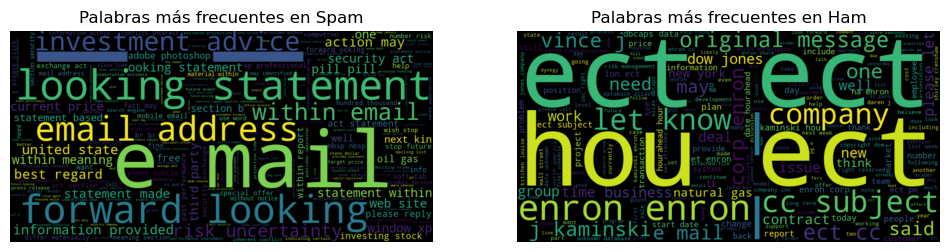

In [18]:
# Display the most frequent words in messages
spam_words = ' '.join(train[train['label_text'] == 'spam']['text_clean2'])
ham_words = ' '.join(train[train['label_text'] == 'ham']['text_clean2'])
spam_wordcloud = WordCloud(width = 1000, height = 500).generate(spam_words)
ham_wordcloud = WordCloud(width = 1000, height = 500).generate(ham_words)

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation = 'bilinear')
plt.title('Most frequent words in Spam')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation = 'bilinear')
plt.title('Most frequent words in Ham')
plt.axis('off')
plt.show()

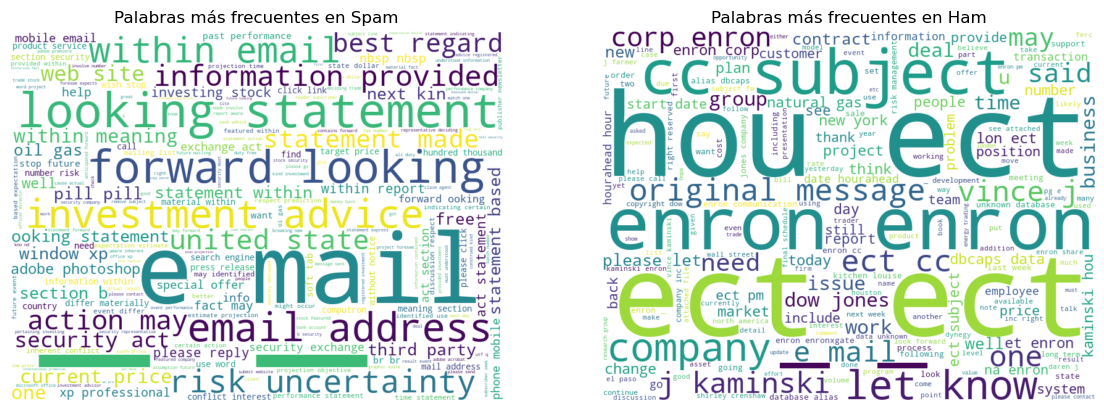

In [20]:
# White background settings for WordClouds
spam_wordcloud = WordCloud(width = 800, height = 600, background_color = 'white').generate(spam_words)
ham_wordcloud = WordCloud(width = 800, height = 600, background_color = 'white').generate(ham_words)

# Display of WordClouds with a white background
plt.figure(figsize=(14, 7))  # Adjust the size of the figure
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Most frequent words in Spam')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Most frequent words in Ham')
plt.axis('off')

# Saving images
plt.savefig('spam_wordcloud.png', bbox_inches='tight')  # Save the image of most frequent words in Spam
plt.savefig('ham_wordcloud.png', bbox_inches='tight')   # Save the image of most frequent words in Ham

# Display images on the screen
plt.show()

### Puedes modificar y que salgan las palabras como un icono, por ejemplo twitter, batman,.... 
test_mask = np.array(Image.open("../input/logo-wordcloud/il_1140xN.1287758547_2nwc.png"))
wordcloud = WordCloud(width=1920,height=1080,mask=test_mask).generate(wordcloud_text)
fig=plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

----------------------------------------------------------------------------------------------------------------------

## ALL PREPROCESSING COULD BE PUT INTO ONE FUNCTION 

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Create a list of stopwords in English
stop_words = set(stopwords.words('english'))

# Create an object for the lemmatiser and the English stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

# Function for pre-processing text and applying normalisation and lemmatisation
def preprocess_text(text):
    # Convert everything to lower case
    text = text.lower()
    
    # Delete WEBS 
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML Tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove the subject (ex: rw: or fw:)
    text = re.sub(r'^\w+:\s*', '', text)
    
    # Remove special characters (will remove all characters other than letters, numbers or blanks)
    # It will remove punctuation marks, special symbols and other unwanted characters. 
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # We remove extra spaces and spaces from the text (\n).
    text  = re.sub(r'\s+', ' ', text)

    # Removing tabs and line breaks
    text = text.replace('\t', ' ').replace('\n', ' ')
    
    # Tokenise text in words
    words = nltk.word_tokenize(text)
    
    # Remove stopwords and single-letter words
    words = [w for w in words if not w in stop_words and len(w) > 1]
    
    # Lemmatising words
    words = [lemmatizer.lemmatize(w) for w in words]
    
    # Putting the words back together into a single text
    text = ' '.join(words)
    
    return text

---------------------------------------------------------------------------------------

# TECHNIQUES THAT COULD ALSO BE APPLIED

Below are several techniques widely used in NLP processes to reduce the number of words in the observations, making the database more optimal and increasing the performance of the models. In my case, I will not apply them to my datasets. 

## REMOVAL OF FREQUENT WORDS

In [51]:
train['text'] = train['text'].apply(lambda x: ' '.join(x))

In [53]:
train['text']

0        software understanding oem software lead tempt...
1        wanted try ci li thought way expensive viagra ...
2        looking cheap high quality software rotated na...
3        internet provider abuse noticed visited illega...
4        localized software language available hello wo...
                               ...                        
30076    var meeting houston shirley think get another ...
30077    credit netco start plan louise attached electr...
30078    start date hourahead hour start date hourahead...
30079    corhshucker daren invoice paid u james armstro...
30080    prosym license hi karolina last word got grant...
Name: text, Length: 30081, dtype: object

In [55]:
from collections import Counter
 
word_count = Counter()
for text in train['text']:
    for word in text.split():
        word_count[word] += 1
        
word_count.most_common(3)

[('_', 57686),
 ('enron', 27534),
 ('ect', 26039),
 ('com', 17256),
 ('please', 17054),
 ('hou', 12609),
 ('e', 12273),
 ('subject', 11148),
 ('u', 10673),
 ('would', 9292),
 ('http', 8738),
 ('message', 8706),
 ('time', 8686),
 ('get', 8425),
 ('email', 8022),
 ('pm', 7865),
 ('new', 7776),
 ('need', 7726),
 ('know', 7667),
 ('cc', 7599)]

In [59]:
FREQUENT_WORDS = set(word for (word, wc) in word_count.most_common(3))
def remove_freq_words(text):
    return " ".join([word for word in text.split() if word not in FREQUENT_WORDS])

In [ ]:
train['text'] = train['text'].apply(lambda x: remove_freq_words(x))

## REMOVAL OF RARE WORDS

In [61]:
RARE_WORDS = set(word for (word, wc) in word_count.most_common()[:-10:-1])
RARE_WORDS

{'authrored',
 'kimich',
 'krell',
 'monet',
 'mphan',
 'mychau',
 'niman',
 'palash',
 'shriley'}

In [ ]:
def remove_rare_words(text):
    return " ".join([word for word in text.split() if word not in RARE_WORDS])

In [ ]:
train['text'] = train['text'].apply(lambda x: remove_rare_words(x))

## SPELLING CORRECTION

In [2]:
text = 'natur is a beaty'

In [10]:
from spellchecker import SpellChecker
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_text = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_text:
            corrected_text.append(spell.correction(word))
        else: 
            corrected_text.append(word)
            
    return " ".join(corrected_text)

In [11]:
correct_spellings(text)

'nature is a beat'